# Base de classification en Allemand

    - Transformers : Summarization : 2 modèles --> 2 Résumés / Puis score de similarités de ces 2 résumés
    Noter que l'on peut faire aussi la similarité des textes (autre note ?) et non du résumé
    - Text classification sur une base de catégories "Presse" 
    - Sentiment analysis : voir si le ton du texte est de même type 
    - Les 2 derniers classifier seronts utilisés en produit scalaire : Par Catégorie : texte1: note1 - texte2 : note2
    et donc sum(notes_par_catégorie) = sum(note1*note2) * 100 au bout (note sur 100)

In [1]:
import pandas as pd
import pke
import spacy
import torch
import stanza
import spacy_stanza
import warnings
import string
import gensim
from gensim.models import KeyedVectors
import enchant    # Pour correction orthographique de synonymes
import numpy as np
import re
from transformers import pipeline
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelWithLMHead, AutoTokenizer
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
warnings.filterwarnings("ignore")

C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


**Selection des modèles NLP : ici ALLEMAND**

In [2]:
# Chargement pour l'utilisation de Spacy  - Français
nlp_de = spacy.load("de_core_news_sm")

In [3]:
dico_spacy = {'de':nlp_de}   # 'en':nlp_en,'de':nlp_de,'es':nlp_es,'pl':nlp_pl  - POUR MEMOIRE
langues = ['en','fr','es','de','pl','ar','tr']

In [4]:
# Chargement du modèle Word2Vec pour utilisation de synonymes
from gensim.models import Word2Vec
model_gensim = gensim.models.KeyedVectors.load_word2vec_format("D:/Users/STG-SDU/Documents/NLP/german.model", binary=True)

In [5]:
# Stopwords Français NLTK + Spacy 
stopWords = list(nlp_de.Defaults.stop_words)
stopwords_de = list(stopwords.words('german'))  
stopwords_de = list(set(stopwords_de + stopWords))
stopwds_lg = {'de':stopwords_de}

In [6]:
# correcteur orthographique pour validation des synonymes OPTIONNEL CAR NON NECESSAIRE
# d = enchant.Dict("de") 

**Sélection des modèles Transformers : Summary - Text Classification - Sentiment Analysis - Similarity**

In [7]:
# Modèles Transformers de Résumé (NB : Ne pas oublier d'ajouter la truncation pour tous les modèles, peut être source d'erreur)
summarizer1 = pipeline("summarization", model="ml6team/mt5-small-german-finetune-mlsum", truncation = "only_first")

In [8]:
# 2e résumé
from transformers import BertTokenizerFast, EncoderDecoderModel
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-german-finetuned-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)
def summarizer2(text):
    inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    output = model.generate(input_ids, attention_mask=attention_mask)
    return tokenizer.decode(output[0], skip_special_tokens=True)

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [9]:
# Plus proche du sentiment analysis ....
text_clf1 = pipeline("text-classification", model = "symanto/xlm-roberta-base-snli-mnli-anli-xnli", truncation = "only_first")   # 10 actégories, voir hugging face

In [ ]:
# "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli" 
# politics, economy, entertainment, environment,sport,health

In [10]:
# Zero shot classification (permet de chosir nos propres thèmes)
text_clf2 = pipeline('zero-shot-classification', model="Sahajtomar/German_Zeroshot",truncation = "only_first")
# ce modèle est un zero shot classification : catégories possibles choisies par mes soins (dans la presse)
candidate_labels = ['Wissenschaft','Politik','Bildung','Nachrichten','Gesundheit','Technologie','Gesellschaft','Sport','Wirtschaft','Kultur','International','Umwelt']

In [11]:
# Sentiment Analysis
sentiment1 = pipeline("text-classification", model = 'oliverguhr/german-sentiment-bert', truncation = "only_first")
# ATTENTION CE MODELE n°2 SE DEFINIT SUR 5 niveaux
sentiment2 = pipeline("text-classification", model = 'nlptown/bert-base-multilingual-uncased-sentiment', truncation = "only_first")

In [13]:
# ENCODAGE AVEC SENTENCE TRANSFORMER
from sentence_transformers import SentenceTransformer,util
encoder = SentenceTransformer("Sahajtomar/German-semantic")
encoder2 = SentenceTransformer("symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli")
def score_similarite(sentence1,sentence2):
    # attention, pour que torch fonctionne en dimension sentence1 (et 2) est une liste simple
    embed1 = encoder.encode(sentence1, convert_to_tensor=True)
    embed2 = encoder.encode(sentence2, convert_to_tensor=True)
    embed3 = encoder2.encode(sentence1, convert_to_tensor=True)
    embed4 = encoder2.encode(sentence2, convert_to_tensor=True)
    return round(float(util.pytorch_cos_sim(embed1,embed2))+float(util.pytorch_cos_sim(embed3,embed4))*100/2,2)

**Selection Data par langues**

In [14]:
data = pd.read_csv('train_data_prep_v1.csv')

In [15]:
data

,pair_id,pair_lang,source_url_1,publish_date_1,source_url_2,publish_date_2,title_1,text_1,meta_description_1,meta_keywords_1,...,text_2,meta_description_2,meta_keywords_2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,1484084337_1484110209,en_en,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",Police in West Virginia say a suspected drunke...,"['Highway Fatal-DUI-West Virginia', 'Martinsbu...",...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",Haitian President Jovenel Moïse has broken wit...,"['CB-Haiti-Political Turmoil', 'Jean', 'Haiti'...",4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,1484396422_1483924666,en_en,https://www.stlucianewsonline.com,Wed Jan 1 21:17:15 2020,https://www.thestar.com,Wed Jan 1 00:00:00 2020,Guyana: Three injured after car crashes into u...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,-,[''],...,BERLIN - A fire at a zoo in western Germany in...,BERLIN - A fire at a zoo in western Germany in...,"['smg2_world', 'smg_europe', 'smg2_news']",4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,1484698254_1483758694,en_en,https://www.teaparty.org,NaN,https://www.timesofisrael.com,NaN,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,NaN,[''],...,"PALM BEACH, United States — US President Donal...",US president says response to rioting by pro-I...,[''],1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,1576314516_1576455088,en_en,https://gadgets.ndtv.com,NaN,https://gadgets.ndtv.com,NaN,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,Zomato on Tuesday announced it has acquired Ub...,['zomato uber eats business acquisition india ...,...,Rapid digitisation and growth in both online b...,The report by Google and Boston Consulting Gro...,['indian online food delivery market to hit us...,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,1484036253_1483894099,en_en,https://news.yahoo.com,Wed Jan 1 08:57:59 2020,NaN,NaN,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,India has approved its third lunar mission mon...,[''],...,NaN,NaN,NaN,1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,1586195445_1598778991,tr_tr,http://www.haberler.com,NaN,https://www.haberler.com,NaN,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...","BM, Aden'de 2 bini aşkın iç göçmenin selden za...","Birleşmiş Milletler (BM), 2 bini aşkın iç göçm...","['Birleşmiş Milletler', 'Twitter', 'Yemen', 'G...",...,BM'den Yemen'de kadınların doğumda ölüm riski ...,BİRLEŞMİŞ Birleşmiş Milletler (BM) dünyanın en...,"['Birleşmiş Milletler', 'Yemen', 'Güncel', 'Ha...",1.0,2.000000,2.000000,4.000000,3.000000,1.000000,1.000000
4960,1590915424_1590940388,tr_tr,https://www.haberler.com,NaN,https://www.aksam.com.tr,NaN,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['Real Madrid', 'İspanya', 'La Liga', 'Futbol'...",...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['İspanya 1. Futbol Ligi', 'la liga', 'koronav...",1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4961,1526157103_1492737005,tr_tr,http://www.samanyoluhaber.com,Thu Feb 20 10:47:10 2020,https://www.fotomac.com.tr,Sun Jan 12 00:00:00 2020,Saray da çare olmadı: 'Borca boğulan dev kulüp...,\n\n\n\n\n\n\n\nİflas noktasındaki kulüplerin ...,SARAY DA ÇARE OLMADI: 'BORCA BOĞULAN DEV KULÜP...,"['Saray', 'da', 'çare', 'olmadı:', ""'Borca"", '...",...,"TFF, resmi internet sitesinden Beşiktaş'ın fai...","Federasyon, Başkan Çebi’nin yaptığı açıklamala...",[''],1.0,2.000000,3.0

In [16]:
# remémorer numéro de ligne - compléter les Nan
data['ligne'] = data.index
data = data.fillna('')

In [17]:
# séparation des datasets, le dernier étant à traduire en plus
allemand = data.loc[data.pair_lang == 'de_de',['ligne','title_1','title_2','text_1','text_2','Geography', 'Entities',
       'Time', 'Narrative', 'Overall', 'Style', 'Tone']].reset_index(drop=True)

**Tests divers et Fonctions nécessaires**

In [18]:
# Résumés, attention le string de la sentence doit être fourni en liste, pour dim ds torch
resume1 = summarizer1(allemand.text_1[1])[0]['summary_text']
resume2 = summarizer1(allemand.text_2[1])[0]['summary_text']
print(resume1)
print(resume2)
print(score_similarite([resume1],[resume2]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Die Jahresmeisterschaft entscheidet der Durchschnitt der besten zehn Serien im Lauf des Jahres.
Die deutsche Melodie Bob Geldofs steht in einer Reihe mit Ohr
3.51


In [19]:
resume1 = summarizer2(allemand.text_1[1])
resume2 = summarizer2(allemand.text_2[1])
print(resume1)
print(resume2)
print(score_similarite([resume1],[resume2]))

Silberdistel Neutras ehrt Jahresmeister Von den Namen her bietet die Siegerehrung wenig Überraschendes, aber die eine oder andere Entscheidung fällt doch sehr knapp aus.
In der Weihnachtszeit ist die Zahl der Weihnachtslieder in Deutschland so sehr gestiegen wie im Vorjahr. Aber es ist schwer, die Weihnachtslieder zu finden.
13.6


In [20]:
# Fonction de calcul du score (produit scalaire) pour résultats de classifaction
def fonction_produit_dotcom(liste_categor, dico_scores1,dico_scores2):
    """"dico scores sont les résultats obtenus pour chaque catégorie des textes 1 et 2"""
    result = 0.0
    for cat in liste_categor:
        result += round(dico_scores1[cat] * dico_scores2[cat],4)
    return result * 100

In [21]:
# transformation des résultats du transformer type1
def transform_text_clf1(liste_dico):
    res = {}
    for dic in liste_dico:
        res[dic['label']] = dic['score']
    return res

In [22]:
# transformation des résultats du transformer type2
def transform_text_clf2(liste_cat,liste_sc):
    res = {}
    for i in range(len(liste_cat)):
        res[liste_cat[i]] = liste_sc[i]
    return res

In [23]:
# Test sur CLF1
liste_categories = ['ENTAILMENT','NEUTRAL','CONTRADICTION']
scores1 = transform_text_clf1(text_clf1(allemand.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(text_clf1(allemand.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_categories, scores1,scores2))

{'ENTAILMENT': 0.029949994757771492, 'NEUTRAL': 0.9699869155883789, 'CONTRADICTION': 6.301972462097183e-05}
{'ENTAILMENT': 0.4363759160041809, 'NEUTRAL': 0.5626500248908997, 'CONTRADICTION': 0.0009741269168443978}
55.88999999999999


In [24]:
classes = text_clf2(allemand.text_1[2], candidate_labels)
scores1 = transform_text_clf2(classes['labels'],classes['scores'])
classes2 = text_clf2(allemand.text_2[2], candidate_labels)
scores2 = transform_text_clf2(classes2['labels'],classes2['scores'])
print(fonction_produit_dotcom(candidate_labels, scores1,scores2))

8.59


In [25]:
sentiment2(allemand.text_1[3],return_all_scores=True)[0]

[{'label': '1 star', 'score': 0.0035264366306364536},
 {'label': '2 stars', 'score': 0.007172734942287207},
 {'label': '3 stars', 'score': 0.0627947449684143},
 {'label': '4 stars', 'score': 0.44613808393478394},
 {'label': '5 stars', 'score': 0.48036807775497437}]

In [26]:
# Tests sentiment analysis
liste_labels = ['positive','negative','neutral']
scores1 = transform_text_clf1(sentiment1(allemand.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment1(allemand.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_labels, scores1,scores2))

{'positive': 0.16152270138263702, 'negative': 0.1037590354681015, 'neutral': 0.7347182631492615}
{'positive': 0.00013322454469744116, 'negative': 0.0002798540808726102, 'neutral': 0.9995868802070618}
73.44000000000001


In [27]:
# ATTENTION CE MODELE SE DEFINIT SUR 4 CLASSES : mixed, positif, negatif, objectif
liste_sentiments = ['1 star','2 stars','3 stars','4 stars','5 stars']
scores1 = transform_text_clf1(sentiment2(allemand.title_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment2(allemand.title_2[3],return_all_scores=True)[0])
scores3 = transform_text_clf1(sentiment2(allemand.text_1[3],return_all_scores=True)[0])
scores4 = transform_text_clf1(sentiment2(allemand.text_2[3],return_all_scores=True)[0])
print(fonction_produit_dotcom(liste_sentiments, scores1,scores2))
print(fonction_produit_dotcom(liste_sentiments, scores3,scores4))

40.39
32.63


In [28]:
# TESTS SCORES DE SIMILARITES : Titres, Textes complets (attention Truncation ...)
print(score_similarite([allemand.title_1[3]],[allemand.title_2[3]]))
print(score_similarite([allemand.text_1[3]],[allemand.text_2[3]]))
print(score_similarite([summarizer1(allemand.text_1[0])[0]['summary_text']],[summarizer1(allemand.text_2[0])[0]['summary_text']]))
print(score_similarite([summarizer2(allemand.text_1[0])],[summarizer2(allemand.text_2[0])]))

-1.18
10.66
0.19
7.83


In [29]:
# Essais de synonymies à utiliser pour sorties PKE, termes prinicpaux
syns = model_gensim.most_similar("Tod", topn=10)
syns

[('Tode', 0.712026834487915),
 ('tragischen_Tod', 0.702599048614502),
 ('Freitod', 0.699851393699646),
 ('Ableben', 0.698720395565033),
 ('Unfalltod', 0.698566198348999),
 ('Selbstmord', 0.6980338096618652),
 ('ploetzlichen_Tod', 0.6917396783828735),
 ('Suizid', 0.6767473220825195),
 ('Tod_Bruders', 0.6639395952224731),
 ('Tod_geliebten', 0.6626296043395996)]

In [30]:
# Fonctions de summarization 
def summarization(texte):
    return summarizer1(texte)[0]['summary_text'], summarizer2(texte)

In [31]:
dico_classifiers = {'text_clf1': 'score_classif1','text_clf2':'score_classif2','sentiment1':'score_sentiment1',
                    'sentiment2': 'score_sentiment2'}
dico_categories = {'text_clf1': liste_categories,'text_clf2':candidate_labels,'sentiment1':liste_labels,
                    'sentiment2': liste_sentiments}

In [32]:
# Fonctions de classification et sentiment analysis
def classification(texte,clf):
    # assume nms des claasifiers et methode de transformation
    if clf == "text_clf1":
        try:
            scores = transform_text_clf1(text_clf1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "text_clf2":                                 
        try:
            classes = text_clf2(texte,dico_categories['text_clf2'])
        except:
            return 'error'
        else:
            return transform_text_clf2(classes['labels'],classes['scores'])                          
    elif clf == "sentiment1":
        try:
            scores = transform_text_clf1(sentiment1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "sentiment2":
        try:
            scores = transform_text_clf1(sentiment2(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    else:
        return 'error'

In [33]:
# Prétraitement NLP pour PKE : suppression des mots de moins de 2 lettres non numériques
def supp_moins_2_lettres_stopwords(phrase,stopwd):
    temp = phrase.split(' ')
    res = ''
    for mot in temp:
        if mot not in stopwd and (len(mot)>2 or (len(mot)>0 and mot[0] in ['0','1','2','3','4','5','6','7','8','9'])):
            res += mot + ' '
    return res[:-1]

In [34]:
# Prétraitement NLP pour PKE : suppression des traits d'union(regroupe)/ des apostrophes / ponctuations
def modif(texte,stopmots):
    # modifications simples des textes : ponctuations, petits mots, stopwords (à faire pour entités et pke textes)
    texte=re.sub('\'',' ',texte)   # suppression apostrophe
    texte=re.sub('-','',texte)    # suppression trait union
    regex = re.compile('[%s]' % re.escape(string.punctuation)) # suppression de toutes les ponctuations
    texte=regex.sub(' ',texte)
    texte = supp_moins_2_lettres_stopwords(texte,stopmots)
    return texte

In [35]:
# Ajout des synonymes (existants en orthographe) à la suite de l'analyse pke
def ajout_synonymes(mot, correct_ortho = False):
    # on ajoute les 10 premiers synonymes existants, on vérifie orthographe (optionnel)
    syns = model_gensim.most_similar(mot,topn = 20)
    if correct_ortho == True:
        res = []
        for m in syns:
            if d.check(m[0]):   #  il y a le mot et son pourcentage d'importance
                res.append(m)
        syns = res
    return syns[:10]

Quelle est la bonne méthodologie à appliquer PKE ??? : Noms Ok - Verbes ? - Adjectifs ? - Noms propres ?
Quelle quantité de mots prendre ?
Ne pas noter les titres seuls ? : trop peu de mots !  Et du coup note peut être forte avec un seul mot !
Supprimer en en-tête les stopwords, ponctuation, les apostrophes - AUTRES ?????

In [36]:
# Choix des paramètres de la méthode : A revoir ?
methode1 = {"NOUN", "PROPN", "ADJ","VERB"}
methode2 = {"NOUN", "PROPN", "ADJ"}
nb_mots = {'meth1': 30, 'meth2':50}

In [37]:
# PKE : Analyse des termes principaux dans les textes et titres 
# Problème 
def transformation_pke_results(res1,res2, correct_ortho = False):
    """
    Transformation des resultats de PKE : Pb bigramme peuvent ne pas être ds les 2 textes mais 1 mot seulement
    liste de clés et dictionnaires de valeurs, bigrammes jouera ainsi de maniere coefficientée 
    Exemple : fuite eau:0.05 --> 3 mots au final : fuite, eau, fuite eau : 0.05
    De plus on ajoute les synonymes issus de gensim en les coefficiant et vérifiant que cela """
    
    liste1 = []; liste2 = [] ; dico1 = {}; dico2 = {}
    for elt in res1:
        liste1.append(elt[0])
        dico1[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:    # bigramme dans ce cas, ajout des 2 mots
            liste = elt[0].split(' ')
            for mot in liste:
                liste1.append(mot)
                dico1[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste1.append(syn[0])   # Ajout du mot 
                        dico1[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
                    
    for elt in res2:
        liste2.append(elt[0])
        dico2[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:
            liste = elt[0].split(' ')
            for mot in liste:
                liste2.append(mot)
                dico2[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste2.append(syn[0])   # Ajout du mot 
                        dico2[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
    
    # similarites entre les 2 listes issus de pke avec poids
    sim = 0
    for elt in liste1:
        if elt in liste2:
            sim += (dico1[elt] + dico2[elt])/2
    return sim

In [38]:
def entites_communes(nlp,text1,text2):
    """"
    Cette première fonction ne regarde que les entités communes : personnes, dates, groupe, localisations
    Elle sera appliquée aux textes et aux titres et cumulé : si cumul en titre et texte : compte double !"""
    
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    nb_commun_ent = 0; liste_commun_ent = []
    nb_commun_geo = 0; liste_commun_geo = []
    nb_commun_dat = 0; liste_commun_dat = []
    
    if len(doc1.ents)>0 and len(doc2.ents)>0:
        liste1 = []; dico1 = {}
        for elt in doc1.ents:
            if elt.label_ == 'PERSON' and ' ' in elt.text:
                mots = elt.text.split(' ')
                for mot in mots:
                    if mot not in liste1:
                        liste1.append(mot)
                        dico1[mot] = elt.label_
            elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                if elt.text not in liste1:
                    liste1.append(elt.text)
                    dico1[elt.text] = elt.label_
        liste2 = []
        for elt in doc2.ents:
            if elt.label_ == 'PERSON' and ' ' in elt.text:
                mots = elt.text.split(' ')
                for mot in mots:
                    if mot not in liste2:
                        liste2.append(mot)
            elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                if elt.text not in liste2:
                    liste2.append(elt.text)
        
        # points communs des listes        
        for elt in liste1:
            if elt in liste2:
                if dico1[elt] == 'LOC':
                    nb_commun_geo += 1
                    liste_commun_geo.append(elt)
                elif dico1[elt] in ['DATE','TIME']:
                    nb_commun_dat += 1
                    liste_commun_dat.append(elt)
                else:
                    nb_commun_ent += 1
                    liste_commun_ent.append(elt)
                    
    return nb_commun_ent, liste_commun_ent,nb_commun_geo, liste_commun_geo,nb_commun_dat, liste_commun_dat

In [39]:
def Creation_features_comparaison(df,langue, test_position = [methode1,methode2]):
    """Création des notes pour classification ensuite"""
    
    resultats = pd.DataFrame(columns = ['summary1_text1','summary2_text1','summary1_text2','summary2_text2',
            'nb_entites_idem','nb_lieux_idem', 'nb_dates_idem','entites_idem','lieux_idem','dates_idem',
            'score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
            'score_sentiment1','score_sentiment2','meth1_similarites','meth2_similarites'])
    
    # initialisation de la langue stanza
    stanza.download(langue)
    nlp_stanza = spacy_stanza.load_pipeline(langue)
    stopmts = stopwds_lg[langue]
    if langue in dico_spacy.keys():
        nlp_spacy = dico_spacy[langue]
    else:
        nlp_spacy = None
        
    for i in tqdm(range(len(df))):
        dico_res = {}
        
        # Summary et comparatifs 
        dico_res['summary1_text1'],dico_res['summary2_text1'] = summarization(df.text_1[i])
        dico_res['summary1_text2'],dico_res['summary2_text2'] = summarization(df.text_2[i])
        dico_res['score_similarite_titres'] = score_similarite([df.title_1[i]],[df.title_2[i]])
        dico_res['score_similarite_resume1'] = score_similarite([dico_res['summary1_text1']],[dico_res['summary1_text2']])
        dico_res['score_similarite_resume2'] = score_similarite([dico_res['summary2_text1']],[dico_res['summary2_text2']])
        
        # analyse de textes classification et de sentiments
        texte1 = df.title_1[i] + ' ' + df.text_1[i]
        texte2 = df.title_2[i] + ' ' + df.text_2[i]
        if len(texte1)>0 and len(texte2)>0:
            for classifier in dico_classifiers.keys():
                scores1 = classification(texte1,classifier)
                scores2 = classification(texte2,classifier)
                if scores1 != 'error' and scores2 != 'error':
                    dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                else:
                    scores1 = classification(df.title_1[i],classifier)
                    scores2 = classification(df.title_2[i],classifier)
                    if scores1 != 'error' and scores2 != 'error':
                        dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                    else:
                        dico_res[dico_classifiers[classifier]] = None
                
        # pré traitement des textes pour entités et PKE
        texte1 = modif(texte1, stopmts)
        texte2 = modif(texte2, stopmts)
        
        # ENTITES COMMUNES : on tient compte des bigrammes Noms qui posent erreurs ex: Joe Biden et Biden 
        # Ici, on considère mieux le CUMUl titres et Textes avec une pondération double pour le titre 
        # Il faut aussi enlever les petits mots donc pré-traitement en texte
        
        nb_ent1,list_ent1,nb_geo1,list_geo1,nb_dat1,list_dat1 = entites_communes(nlp_stanza,df.title_1[i],df.title_2[i])
        nb_ent2,list_ent2,nb_geo2,list_geo2,nb_dat2,list_dat2 = entites_communes(nlp_stanza,df.text_1[i],df.text_2[i])
        if nlp_spacy != None:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = entites_communes(nlp_spacy,df.title_1[i],df.title_2[i])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = entites_communes(nlp_spacy,df.text_1[i],df.text_2[i])
        else:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = (0,[],0,[],0,[])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = (0,[],0,[],0,[])
        dico_res['nb_entites_idem'] = nb_ent1 * 2 + nb_ent2 + nb_ent3 * 2 + nb_ent4
        dico_res['nb_lieux_idem'] = nb_geo1  * 2 + nb_geo2 + nb_geo3  * 2 + nb_geo4
        dico_res['nb_dates_idem'] = nb_dat1 * 2 + nb_dat2 + nb_dat3 * 2 + nb_dat4
        # fusion des listes en supprimant les doublons
        dico_res['entites_idem'] = list(set(list_ent1+list_ent2+ list_ent3+list_ent4))
        dico_res['lieux_idem'] = list(set(list_geo1+list_geo2+list_geo3+list_geo4))
        dico_res['dates_idem'] = list(set(list_dat1+list_dat2+list_dat3+list_dat4))
        
        for j,meth in enumerate(test_position):
            nom ='meth'+str(j+1)
            nb_mots_meth = nb_mots[nom]
            if len(texte1)>0 and len(texte2)>0:
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte1,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases3 = extractor.get_n_best(n=nb_mots_meth)
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte2,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases4 = extractor.get_n_best(n=nb_mots_meth)
                dico_res[nom+'_similarites'] = round(100*transformation_pke_results(keyphrases3,keyphrases4),1)
            else:
                dico_res[nom+'_similarites'] = 'Error'

        resultats.loc[len(resultats)] = dico_res
        
    newdf = pd.concat([df,resultats],axis=1)
    return newdf

In [56]:
# Attention, problème de mémoire : faire par steps de 200, pb avec le 377 / 712 mais texte pourri
similarites = Creation_features_comparaison(allemand[376:377].reset_index(drop=True),'de')

2021-12-17 16:50:45 INFO: Downloading default packages for language: de (German)...
2021-12-17 16:50:46 INFO: File exists: C:\Users\stg-sdu\stanza_resources\de\default.zip.


OSError: [Errno 28] No space left on device

In [49]:
#similarites.to_csv('corpus_de_notes.csv')   # A Utiliser pour le premier
precedent = pd.read_csv('corpus_de_notes.csv',index_col=0)
similarites2 = pd.concat([precedent,similarites], axis=0)
similarites2 = similarites2.reset_index(drop=True)
similarites2.to_csv('corpus_de_notes.csv')

In [50]:
# pour vérifivation concat
precedent = pd.read_csv('corpus_de_notes.csv',index_col=0)
precedent

,ligne,title_1,title_2,text_1,text_2,Geography,Entities,Time,Narrative,Overall,...,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,1581,Dschungelcamp 2020: Marco Cerullo - Übernimmt ...,Dschungelcamp bei RTL: Ex-Minister Günther Kra...,Kürzlich war er noch bei „Bachelor in Paradise...,"Ex-Bundesverkehrsminister Günther Krause, 66, ...",2.333333,2.666667,3.0,4.000000,3.000000,...,[],7.94,0.19,7.83,20.27,20.27,20.27,20.27,58.5,40.7
1,1582,Silberdistel Neutras ehrt Jahresmeister,Fröhliche Weise mit ernster Botschaft,Silberdistel Neutras ehrt Jahresmeister\n\nVon...,Fröhliche Weise mit ernster Botschaft\n\nMit s...,2.000000,4.000000,1.0,4.000000,3.666667,...,[],3.22,3.51,13.60,96.21,96.21,96.21,96.21,23.8,6.9
2,1583,Das grosse Rätsel um die Flucht des Autozaren,Überraschende Flucht aus Japan: Ex-Renault-Bos...,Tragen Sie mit Hinweisen zu diesem Artikel bei...,Der in Japan auf Kaution freigelassene frühere...,1.000000,1.333333,1.0,1.000000,1.000000,...,[],7.18,-2.00,20.76,11.07,11.07,11.07,11.07,151.5,173.0
3,1584,Zum Jahresende legen die Velpker noch mal rich...,Léon Berben auf der Vater-Orgel : Ein Meisterk...,Das alte Jahr ausklingen lassen und das neue m...,Melle. Die Ev. luth. St. Petri-Kirchengemeinde...,3.000000,4.000000,1.0,4.000000,4.000000,...,[],-1.18,3.89,7.50,16.50,16.50,16.50,16.50,0.0,137.4
4,1585,Neun Personen festgenommen: Viel Arbeit für di...,Polizei berichtet von ruhiger Silvesternacht,Neun Personen festgenommen: Viel Arbeit für di...,Lediglich zwei Verstöße gegen das Feuerwerksve...,4.000000,3.000000,1.0,3.000000,3.000000,...,[],16.37,6.58,-5.94,90.97,90.97,90.97,90.97,36.1,31.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2706,"Wer seine Vignette so klebt, zahlt 240 Franken",Mann fuchtelt mit Waffe in Restaurant herum,«Ob es Unwissenheit oder das Werk von Schlaume...,Kurz nach 23.30 Uhr am Mittwochabend ging bei ...,1.000000,2.000000,1.0,4.000000,3.000000,...,[],4.28,1.91,31.22,99.82,99.82,99.82,99.82,395.3,155.0
372,2707,"VIRUS: US-Bundesstaaten Maryland, Ohio und Was...",VIRUS: G7-Außenministertreffen in Pittsburgh a...,WASHINGTON (dpa-AFX) - Wegen der Ausbreitung d...,WASHINGTON (dpa-AFX) - Das anstehende Treffen ...,2.500000,4.000000,1.0,2.500000,2.500000,...,[],13.15,2.33,15.25,0.55,0.55,0.55,0.55,35.1,62.8
373,2708,Schweizer Medizinaltechnik – EU erhöht den Druck,Am WEF soll der Bundesrat die Medtech-Branche ...,Die EU erhöht den Druck – die Schweizer Medizi...,Ein dringendes Anliegen hat aber die Schweizer...,1.333333,2.000000,1.0,1.333333,1.000000,...,[],11.61,12.37,28.11,97.31,97.31,97.31,97.31,104.5,161.0
374,2709,Bayern fördert ab März Ausbau von Gigabit-Inte...,Bayern startet neue Gigabit-Internet-Förderung,Glasfaserausbau - Ein Leerrohr für Glasfaser w...,Bayern startet neue Gigabit-Internet-Förderung...,1.000000,1.000000,1.0,1.000000,1.000000,...,[],34.41,28.17,37.50,99.00,99.00,99.00,99.00,201.8,41.0


## Classification Sklearn Pycaret

In [57]:
allemand = pd.read_csv('corpus_de_notes.csv',index_col=0)

In [58]:
# attention certains textes ne sont pas fournies et donc mis en "Error" : A supprimer donc
# On pourrait éventuellement tester en ne prenant plus les meth similarités ds les predicteurs
allemand = allemand[allemand.meth1_similarites!='Error']

,ligne,title_1,title_2,text_1,text_2,Geography,Entities,Time,Narrative,Overall,...,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
10,1591,Atomkraftwerk Philippsburg stillgelegt: KKP2 h...,NaN,Atomkraftwerk Philippsburg stillgelegt\n\nKKP2...,NaN,2.000000,3.000000,1.000000,4.000000,3.000000,...,[],4.47,0.71,-5.16,42.84,42.84,42.84,42.84,Error,Error
90,1671,NaN,Koalitionsverhandlungen in Wien zwischen ÖVP u...,NaN,Die Koalitionsverhandlungen in Österreich zwis...,1.000000,1.333333,1.000000,1.000000,1.000000,...,[],-14.28,4.28,-2.46,22.86,22.86,22.86,22.86,Error,Error
129,1710,NaN,"Angriff auf US-Vertretung in Bagdad ""Die Botsc...",NaN,Irans Oberhaupt hat scharf auf US-Präsident Tr...,1.000000,2.500000,1.000000,2.000000,2.000000,...,[],-2.86,3.70,-10.64,31.99,31.99,31.99,31.99,Error,Error
173,1754,"""Tatort"": Friederike Kempter verabschiedet sic...",NaN,"WDR Westdeutscher Rundfunk\n\n""Tatort"": Friede...",NaN,1.000000,1.333333,1.000000,1.000000,1.000000,...,[],-2.22,4.03,4.63,45.21,45.21,45.21,45.21,Error,Error
194,1775,"""Tatort"": Friederike Kempter verabschiedet sic...",NaN,"Köln (ots) - Die Münsteraner ""Tatort""-Kommissa...",NaN,1.000000,1.666667,1.000000,1.000000,1.000000,...,[],-2.22,12.87,5.58,45.50,45.50,45.50,45.50,Error,Error
207,1788,NaN,"Straßen, Schienen, Kitas: Soll der Staat mehr ...",NaN,"Straßen, Schienen, Kitas : Soll der Staat mehr...",1.000000,3.666667,1.000000,1.666667,1.333333,...,[],3.98,-2.18,3.49,31.09,31.09,31.09,31.09,Error,Error
249,2584,Preise für Schnittblumen ziehen rund um den Va...,NaN,Die Preise für Schnittblumen in Deutschland li...,NaN,1.000000,3.333333,3.666667,4.000000,3.666667,...,[],-6.84,10.08,3.79,23.49,23.49,23.49,23.49,Error,Error
287,2622,NaN,NaN,NaN,NaN,1.333333,3.333333,3.000000,2.666667,2.666667,...,[],51.00,51.00,51.00,36.12,36.12,36.12,36.12,Error,Error
323,2658,NaN,Nach der Wahl: Hamburger CDU-Fraktion vor der ...,NaN,Anzeige\n\nNach zwei Nächten und vielen Gesprä...,1.000000,1.666667,1.000000,1.333333,1.333333,...,[],3.48,17.12,-2.24,31.14,31.14,31.14,31.14,Error,Error
324,2659,NaN,Deutsche IT-Branche legt 2020 zu – Großer Fach...,NaN,"Umsatz soll um 1,5 Prozent steigen – 39.000 ne...",1.000000,1.000000,1.000000,2.000000,2.000000,...,[],-9.52,7.63,-2.46,46.10,46.10,46.10,46.10,Error,Error


In [59]:
allemand = allemand.round({'Geography':0, 'Entities':0,'Time':0, 'Narrative':0, 'Overall':0, 'Style':0, 'Tone':0})

In [60]:
partiel = allemand[['Geography', 'Entities','Time', 'Narrative', 'Overall', 'Style', 'Tone']].astype('int32')

In [61]:
allemand = pd.concat([allemand[['ligne', 'title_1', 'title_2', 'text_1', 'text_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2']],
        partiel,allemand[['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
       'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
       'score_sentiment2', 'meth1_similarites', 'meth2_similarites']]],axis=1)

In [62]:
allemand

,ligne,title_1,title_2,text_1,text_2,summary1_text1,summary2_text1,summary1_text2,summary2_text2,Geography,...,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,1581,Dschungelcamp 2020: Marco Cerullo - Übernimmt ...,Dschungelcamp bei RTL: Ex-Minister Günther Kra...,Kürzlich war er noch bei „Bachelor in Paradise...,"Ex-Bundesverkehrsminister Günther Krause, 66, ...",Dschungelcamp-Kandidat Marco Cerullo suchte in...,Dschungelcamp - Kandidat Marco Cerullo suchte ...,Der frühere Politiker Günther Krause hatte 199...,"Ex - Bundesverkehrsminister Günther Krause, 66...",2,...,[],7.94,0.19,7.83,20.27,20.27,20.27,20.27,58.5,40.7
1,1582,Silberdistel Neutras ehrt Jahresmeister,Fröhliche Weise mit ernster Botschaft,Silberdistel Neutras ehrt Jahresmeister\n\nVon...,Fröhliche Weise mit ernster Botschaft\n\nMit s...,Die Jahresmeisterschaft entscheidet der Durchs...,Silberdistel Neutras ehrt Jahresmeister Von de...,Die deutsche Melodie Bob Geldofs steht in eine...,In der Weihnachtszeit ist die Zahl der Weihnac...,2,...,[],3.22,3.51,13.60,96.21,96.21,96.21,96.21,23.8,6.9
2,1583,Das grosse Rätsel um die Flucht des Autozaren,Überraschende Flucht aus Japan: Ex-Renault-Bos...,Tragen Sie mit Hinweisen zu diesem Artikel bei...,Der in Japan auf Kaution freigelassene frühere...,"Sehr gut möglich, dass die Geschichte dieser F...",Der libanesischen Automanager Carlos Ghosn ist...,Der in Japan auf Kaution freigelassene frühere...,"Er sei "" nicht länger eine Geisel des manipuli...",1,...,[],7.18,-2.00,20.76,11.07,11.07,11.07,11.07,151.5,173.0
3,1584,Zum Jahresende legen die Velpker noch mal rich...,Léon Berben auf der Vater-Orgel : Ein Meisterk...,Das alte Jahr ausklingen lassen und das neue m...,Melle. Die Ev. luth. St. Petri-Kirchengemeinde...,Das alte Jahr ausklingen lassen und das neue m...,Das alte Jahr ausklingen lassen und das neue m...,Der deutsche Musiker Léon Berben feiert seine ...,Der Interpret genießt in der festlich erleucht...,3,...,[],-1.18,3.89,7.50,16.50,16.50,16.50,16.50,0.0,137.4
4,1585,Neun Personen festgenommen: Viel Arbeit für di...,Polizei berichtet von ruhiger Silvesternacht,Neun Personen festgenommen: Viel Arbeit für di...,Lediglich zwei Verstöße gegen das Feuerwerksve...,Vor allem in der Stadt und Agglomeration war d...,Vor allem in der Stadt und Agglomeration war d...,Die Polizei hat zwei Verstöße gegen das Feuerw...,Der Inhalt ist älter als 30 Stunden und steht ...,4,...,[],16.37,6.58,-5.94,90.97,90.97,90.97,90.97,36.1,31.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2706,"Wer seine Vignette so klebt, zahlt 240 Franken",Mann fuchtelt mit Waffe in Restaurant herum,«Ob es Unwissenheit oder das Werk von Schlaume...,Kurz nach 23.30 Uhr am Mittwochabend ging bei ...,Werde Praktikant Du willst die Texte nicht nur...,Die Aussenredaktion St. Gallen sucht per sofor...,Ein Mann hatte eine Waffe gezogen und damit he...,Werde Praktikant Du willst die Texte nicht nur...,1,...,[],4.28,1.91,31.22,99.82,99.82,99.82,99.82,395.3,155.0
372,2707,"VIRUS: US-Bundesstaaten Maryland, Ohio und Was...",VIRUS: G7-Außenministertreffen in Pittsburgh a...,WASHINGTON (dpa-AFX) - Wegen der Ausbreitung d...,WASHINGTON (dpa-AFX) - Das anstehende Treffen ...,WASHINGTON (dpa-AFX) - Wegen der Ausbreitung d...,WASHINGTON ( dpa ) - Wegen der Ausbreitung des...,Das Treffen der Außenminister der G7-Staaten w...,WASHINGTON ( dpa ) - Das anstehende Treffen de...,2,...,[],13.15,2.33,15.25,0.55,0.55,0.55,0.55,35.1,62.8
373,2708,Schweizer Medizinaltechnik – EU erhöht den Druck,Am WEF soll der Bundesrat die Medtech-Branche ...,Die EU erhöht den Druck – die Schweizer Medizi...,Ein dringendes Anliegen hat aber die Schweizer...,Im Ringen um den Rahmenvertrag malt die EU ihr...,Die EU erhöht den Druck die Schweizer Medizina...,Ein dringendes Anliegen hat aber die Schweizer...,Bisher anerkennt d

In [63]:
predicteurs = ['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1',
    'score_similarite_resume2', 'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites',
    'meth2_similarites']
# 2e test sans les predicteurs entites et méthodes similarités
# predicteurs1 = ['score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
#            'score_sentiment1','score_sentiment2']

In [64]:
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
german_classif = setup(data = allemand[predicteurs1 + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

In [65]:
lr = create_model('lr')
rf = create_model('rf')
xgb = create_model('xgboost')
ada = create_model('ada')
lda = create_model('lda')  # linear discriminant
knn = create_model('knn')
mlp = create_model('mlp')
svm = create_model('svm')
rbfsvm = create_model('rbfsvm')
nb = create_model('nb')
gpc = create_model('gpc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5556,0.8165,0.5286,0.5628,0.5196,0.3910,0.4061
1,0.3704,0.5979,0.3304,0.3222,0.3229,0.1290,0.1396
2,0.4815,0.7768,0.4286,0.3646,0.4099,0.2868,0.2986
3,0.5000,0.7554,0.4167,0.3841,0.4282,0.2944,0.3090
4,0.5385,0.7172,0.4861,0.4780,0.4912,0.3486,0.3678
5,0.6538,0.8300,0.6056,0.7033,0.6207,0.5175,0.5326
6,0.5769,0.7507,0.5361,0.5641,0.5538,0.4234,0.4341
7,0.3462,0.6598,0.3000,0.2919,0.2921,0.0675,0.0750
8,0.5769,0.8596,0.4841,0.4936,0.5291,0.4042,0.4124
9,0.5385,0.7627,0.4563,0.5271,0.5031,0.3276,0.3677


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5556,0.7922,0.5286,0.5556,0.5259,0.3978,0.4103
1,0.4444,0.6588,0.4348,0.4370,0.4362,0.2500,0.2519
2,0.4815,0.7166,0.4473,0.4318,0.4461,0.2935,0.2986
3,0.4231,0.6558,0.3472,0.3462,0.3791,0.2008,0.2039
4,0.4615,0.7065,0.4167,0.4615,0.4516,0.2541,0.2580
5,0.6154,0.8385,0.5556,0.4990,0.5508,0.4661,0.4838
6,0.4615,0.6237,0.4028,0.4287,0.4099,0.2587,0.2838
7,0.4231,0.6198,0.3833,0.4162,0.4061,0.1942,0.1995
8,0.5385,0.7885,0.4623,0.5214,0.5262,0.3646,0.3684
9,0.4231,0.7072,0.3720,0.4192,0.4115,0.2025,0.2063


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4815,0.7698,0.4473,0.4593,0.4650,0.3000,0.3023
1,0.4444,0.6900,0.4393,0.4508,0.4405,0.2541,0.2575
2,0.4444,0.6588,0.4116,0.3498,0.3833,0.2416,0.2513
3,0.4231,0.6696,0.3611,0.3173,0.3626,0.1975,0.2032
4,0.5000,0.6907,0.4667,0.5069,0.4851,0.3074,0.3141
5,0.5385,0.7769,0.5000,0.4872,0.5077,0.3697,0.3767
6,0.4615,0.5776,0.3972,0.4441,0.4378,0.2571,0.2644
7,0.3462,0.6117,0.2917,0.3022,0.3088,0.0811,0.0847
8,0.5769,0.8007,0.5595,0.6416,0.5950,0.4291,0.4352
9,0.3462,0.6041,0.2877,0.3585,0.3329,0.0714,0.0752


predicteurs : Les plus satisfaisants : ADA - LDA - KNN - LR : pluto moins bien en accuracy .... <br/>
predicteurs 1 : Les plus satisfaisants : LR - LDA - RF - XGB - NB : environ 40% accuracy

In [66]:
essai_classif = allemand[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites','meth2_similarites']]

In [67]:
# Si on veut utiliser faire un classemen,t supprimer ligne error puis changer les types pour meth1 meth2
essai_classif = essai_classif[essai_classif.meth1_similarites != 'Error']
essai_classif['meth1_similarites'] = essai_classif['meth1_similarites'].astype('float')
essai_classif['meth2_similarites'] = essai_classif['meth2_similarites'].astype('float')
essai_classif.dtypes

Geography                     int32
Entities                      int32
Time                          int32
Narrative                     int32
Overall                       int32
Style                         int32
Tone                          int32
nb_entites_idem               int64
nb_lieux_idem                 int64
nb_dates_idem                 int64
score_similarite_titres     float64
score_similarite_resume1    float64
score_similarite_resume2    float64
score_classif1              float64
score_classif2              float64
score_sentiment1            float64
score_sentiment2            float64
meth1_similarites           float64
meth2_similarites           float64
dtype: object

In [69]:
Xtrain = essai_classif[predicteurs + ['Overall']]
german_classif = setup(data = Xtrain,  target = 'Overall', html=False, silent=True, verbose=False)
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.7562,0.4548,0.5000,0.4503,0.3045,0.3371
1,0.6154,0.8564,0.5887,0.5930,0.5964,0.4769,0.4818
2,0.5385,0.7778,0.4722,0.4895,0.4881,0.3607,0.3830
3,0.4615,0.7551,0.4250,0.4692,0.4634,0.2646,0.2652
4,0.5600,0.7775,0.5333,0.4693,0.5055,0.3943,0.4141
5,0.4800,0.8258,0.4646,0.5219,0.4951,0.3070,0.3090
6,0.4800,0.7321,0.4562,0.5571,0.5024,0.3085,0.3132
7,0.4800,0.7403,0.4458,0.4732,0.4667,0.2873,0.2919
8,0.4800,0.7819,0.4542,0.4825,0.4697,0.2904,0.2950
9,0.4800,0.7859,0.4562,0.4786,0.4749,0.3011,0.3030


In [70]:
# predictions = predict_model(rf)  # ne marche pas ????
# predictions

In [73]:
# random Forest simple sur scikit learn
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [76]:
rf = RandomForestClassifier()
rf.fit(Xtrain[:260],ytrain[:260])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
res_rf = rf.predict(Xtrain[260:])
res_rf = pd.concat([Xtrain[260:],ytrain[260:],pd.DataFrame(res_rf,columns = ['RF'],index = range(260,364))],axis=1)
res_rf

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,RF
260,1,4,0,5.51,23.16,19.47,98.14,98.14,98.14,98.14,101.8,103.6,2,2
261,1,1,0,30.10,6.05,8.03,99.89,99.89,99.89,99.89,156.8,73.8,1,2
262,0,10,0,19.96,14.48,24.22,0.18,0.18,0.18,0.18,211.5,191.1,2,1
263,0,2,0,7.78,5.96,16.15,90.85,90.85,90.85,90.85,45.0,63.5,1,3
264,0,0,0,22.16,1.51,16.81,17.45,17.45,17.45,17.45,65.9,26.7,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0,1,0,4.28,1.91,31.22,99.82,99.82,99.82,99.82,395.3,155.0,3,1
360,1,2,0,13.15,2.33,15.25,0.55,0.55,0.55,0.55,35.1,62.8,2,2
361,3,2,0,11.61,12.37,28.11,97.31,97.31,97.31,97.31,104.5,161.0,1,1
362,0,6,0,34.41,28.17,37.50,99.00,99.00,99.00,99.00,201.8,41.0,1,1


In [81]:
# 38 OK sur 104 -44 une catégorie près, 20 à 2 catégories, et 4 à 3 !!!! Franchement décevant
from sklearn.metrics import confusion_matrix
confusion_matrix(res_rf.Overall,res_rf.RF)

array([[19,  7,  2,  2],
       [17,  6,  5,  8],
       [ 5,  3,  1,  9],
       [ 2,  3,  3, 12]], dtype=int64)

In [82]:
res_rf[(res_rf.Overall==4) & (res_rf.RF ==1)]

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,RF
289,4,0,0,-0.95,4.96,14.23,0.04,0.04,0.04,0.04,187.5,215.3,4,1
352,0,0,0,-0.49,51.00,51.00,97.71,97.71,97.71,97.71,930.2,539.3,4,1


In [87]:
print(allemand.summary1_text1[289])
print(allemand.summary1_text2[289])

Findet Europa doch noch zu einer geeinten Antwort auf Corona? Ein Videogipfel soll
Die EU-Staaten wollen gemeinsam handeln und eine starke Antwort auf die


In [83]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, Xtrain, ytrain, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([ 9,  8,  7,  6,  2,  1,  0,  4, 10, 11,  5,  3], dtype=int64)

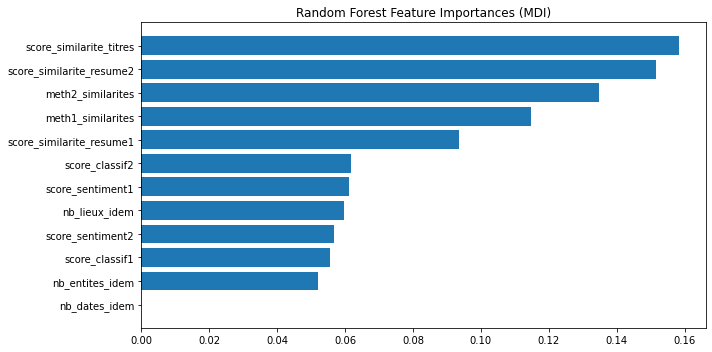

In [84]:
import matplotlib
import matplotlib.pyplot as plt
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(predicteurs))
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.array(predicteurs)[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain[:50],ytrain[:50])
res_lda = lda.predict(Xtrain[50:])
res_final = pd.concat([res_rf[['Overall','RF']],pd.DataFrame(res_lda,columns = ['LDA'],index = range(50,67))],axis=1)
res_final

In [ ]:
from numpy import around
import numpy
np.set_printoptions(suppress=True)  # supprime notation exp
res_lda2 = around(lda.predict_proba(Xtrain[50:])*100, decimals=2)
res_lda2

In [ ]:
res_rf2 = around(rf.predict_proba(Xtrain[50:])*100, decimals=2)
res_rf2

**_Remarquer que la classification ne tient pas compte du fait que c'est ordonné en classement 1-2-3-4 : ce qui est TRES important (ex : ligne 55% de 1 - 43% de 4) !! : il faudrait donc faire ressortir un score avec les probas plutot !!!_**

In [ ]:
# Nouveau programme basé sur les scores probas : si plus de 50% mettre catégorie obtenue sinon, faire la somme 1-2 et 3/4 
# et prendre le plus gros score puis regarder si ce sore > 65% alors à ce moment là prendre le plus gros de la catégorie 
# sinon prendre 2 ou 3
def choix_classes(score_prob):
    classe_finale = []
    for i in range(len(score_prob)):
        res = list(score_prob[i,:])
        max_res = max(res)
        if max_res > 50:
            classe_finale.append(res.index(max_res)+1)
        else:
            som1 = res[0]+res[1]
            som2 = res[2]+res[3]
            if som1 > som2:
                if som1 >= 65:
                    choix = 1 if res[0]>res[1] else 2
                else:
                    choix = 2
            else:
                if som2 >= 65:
                    choix = 4 if res[3]>res[2] else 3
                else:
                    choix = 3
            classe_finale.append(choix)
    return classe_finale

In [ ]:
liste_rf = choix_classes(res_rf2)
liste_lda = choix_classes(res_lda2)
res_final = pd.concat([res_final,pd.DataFrame(liste_lda,columns = ['LDA_Prob'],index = range(50,67)),
                       pd.DataFrame(liste_rf,columns = ['RF_Prob'],index = range(50,67))],axis=1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(Xtrain[:50],ytrain[:50])
res_knn = knn.predict(Xtrain[50:])
liste_knn = choix_classes(around(knn.predict_proba(Xtrain[50:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['KNN'],index = range(50,67)),
                      pd.DataFrame(liste_knn,columns = ['KNN_Prob'],index = range(50,67))],axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(Xtrain[:50],ytrain[:50])
res_logreg = logreg.predict(Xtrain[50:])
liste_logreg = choix_classes(around(logreg.predict_proba(Xtrain[50:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_logreg,columns = ['LOGR'],index = range(50,67)),
                      pd.DataFrame(liste_knn,columns = ['LOGR_Prob'],index = range(50,67))],axis=1)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(Xtrain[:50],ytrain[:50])
res_ada = ada.predict(Xtrain[50:])
liste_ada = choix_classes(around(ada.predict_proba(Xtrain[50:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['ADA'],index = range(50,67)),
                      pd.DataFrame(liste_knn,columns = ['ADA_Prob'],index = range(50,67))],axis=1)
res_final = res_final [['Overall','RF','LDA','KNN','LOGR','ADA','RF_Prob','LDA_Prob','KNN_Prob','LOGR_Prob','ADA_Prob']]

## REGRESSION Sklearn Pycaret

In [ ]:
from pycaret.regression import *
from sklearn.linear_model import LinearRegression
allemand = pd.read_csv('corpus_de_notes.csv',index_col=0)
allemand = allemand[allemand.meth1_similarites!='Error']
german_classif = setup(data = allemand[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

In [ ]:
lr = create_model('lr')
rr = create_model('lasso')
etr = create_model('et')
svr = create_model('svm')
adar = create_model('ada')
mlpr = create_model('mlp')

In [ ]:
# Linear Regression simple sur scikit learn
essai_classif = allemand[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites','meth2_similarites']]
lr = LinearRegression()
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [ ]:
lr.fit(Xtrain[:50],ytrain[:50])
res_lr = lr.predict(Xtrain[50:])
res_lr = pd.concat([Xtrain[50:],ytrain[50:],pd.DataFrame(res_lr,columns = ['LR'],index = range(50,67))],axis=1)
res_lr

In [ ]:
res_final = pd.concat([res_final,res_lr['LR']],axis=1)

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression()
pls.fit(Xtrain[:50],ytrain[:50])
res_pls = list(pls.predict(Xtrain[50:]).flatten())
res_pls = pd.concat([res_lr,pd.DataFrame(res_pls,columns = ['PLS'],index = range(50,67))],axis=1)
res_pls

In [ ]:
res_final = pd.concat([res_final,res_pls['PLS']],axis=1)